In [3]:
import re
import logging

import numpy as np
import pandas as pd
import spacy
import torch
from torchtext import data

NLP = spacy.load('en')
MAX_CHARS = 20000
VAL_RATIO = 0.2
LOGGER = logging.getLogger("toxic_dataset")


def tokenizer(comment):
    comment = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", "!", comment)
    comment = re.sub(r"\,+", ",", comment)
    comment = re.sub(r"\?+", "?", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [x.text for x in NLP.tokenizer(comment) if x.text != " "]


def prepare_csv(seed=999):
    df_train = pd.read_csv("data/train.csv")
    df_train["comment_text"] = df_train.comment_text.str.replace("\n", " ")
    idx = np.arange(df_train.shape[0])
    np.random.seed(seed)
    np.random.shuffle(idx)
    val_size = int(len(idx) * VAL_RATIO)
    df_train.iloc[idx[val_size:], :].to_csv(
        "cache/dataset_train.csv", index=False)
    df_train.iloc[idx[:val_size], :].to_csv(
        "cache/dataset_val.csv", index=False)
    df_test = pd.read_csv("data/test.csv")
    df_test["comment_text"] = df_test.comment_text.str.replace("\n", " ")
    df_test.to_csv("cache/dataset_test.csv", index=False)


def get_dataset(fix_length=100, lower=False, vectors=None):
    if vectors is not None:
        # pretrain vectors only supports all lower cases
        lower = True
    LOGGER.debug("Preparing CSV files...")
    prepare_csv()
    comment = data.Field(
        sequential=True,
        fix_length=fix_length,
        tokenize=tokenizer,
        pad_first=True,
        tensor_type=torch.cuda.LongTensor,
        lower=lower
    )
    LOGGER.debug("Reading train csv file...")
    train, val = data.TabularDataset.splits(
        path='cache/', format='csv', skip_header=True,
        train='dataset_train.csv', validation='dataset_val.csv',
        fields=[
            ('id', None),
            ('comment_text', comment),
            ('toxic', data.Field(
                use_vocab=False, sequential=False, tensor_type=torch.cuda.ByteTensor)),
            ('severe_toxic', data.Field(
                use_vocab=False, sequential=False, tensor_type=torch.cuda.ByteTensor)),
            ('obscene', data.Field(
                use_vocab=False, sequential=False, tensor_type=torch.cuda.ByteTensor)),
            ('threat', data.Field(
                use_vocab=False, sequential=False, tensor_type=torch.cuda.ByteTensor)),
            ('insult', data.Field(
                use_vocab=False, sequential=False, tensor_type=torch.cuda.ByteTensor)),
            ('identity_hate', data.Field(
                use_vocab=False, sequential=False, tensor_type=torch.cuda.ByteTensor)),
        ])
    LOGGER.debug("Reading test csv file...")
    test = data.TabularDataset(
        path='cache/dataset_test.csv', format='csv', skip_header=True,
        fields=[
            ('id', None),
            ('comment_text', comment)
        ])
    LOGGER.debug("Building vocabulary...")
    comment.build_vocab(
        train, val, test,
        max_size=20000,
        min_freq=50,
        vectors=vectors
    )
    LOGGER.debug("Done preparing the datasets")
    return train, val, test,comment


def get_iterator(dataset, batch_size, train=True, shuffle=True, repeat=False):
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=0,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    return dataset_iter

In [4]:
train,val,test,comment_field = get_dataset(vectors = 'glove.42B.300d')

In [5]:
train_iter,val_iter,test_iter = data.Iterator.splits((train,val,test),sort_key = lambda x:len(x.Text), batch_sizes = (32,256,256),device=0)

In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class BiLSTMSentiment(nn.Module):

    def __init__(self,embedding_dim, hidden_dim,vocab, label_size, use_gpu, batch_size, dropout=0.5):
        super(BiLSTMSentiment, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_gpu = use_gpu
        self.batch_size = batch_size
        self.dropout = dropout
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim*2, label_size)
        self.hidden=[]

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        if self.use_gpu:
            self.hidden = (Variable(torch.zeros(2, self.batch_size, self.hidden_dim).cuda()),
                    Variable(torch.zeros(2, self.batch_size, self.hidden_dim).cuda()))
        else:
            self.hidden=(Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                    Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))
            
        return self.hidden
    def update_hidden(self,h):
        self.hidden = h

    def forward(self, sentence,hidden):
        self.update_hidden(hidden)
        x = self.embeddings(sentence).view(len(sentence), self.embeddings(sentence).shape[1], -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y =self.hidden2label(lstm_out[-1])
        return y
    

In [7]:
Embedding_dim = 300
EPOCHS=10
Hidden_dim = 100
vocab = comment_field.vocab
label_size=6
use_gpu=True
batch_size=32

In [8]:

mModal = BiLSTMSentiment(Embedding_dim,Hidden_dim,vocab,label_size,use_gpu,batch_size).cuda()
hidden = mModal.init_hidden()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mModal.parameters(), lr=1e-3)

In [9]:
def repackage_hidden(h):
    if type(h)==Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

In [10]:
all_lossses=[]
for epoch in range(EPOCHS):
    index=0
    g_loss=0
    for examples in get_iterator(train,batch_size=32,train=True,shuffle=True,repeat=False):
        optimizer.zero_grad()
        x = examples.comment_text
        y = torch.stack([
            examples.toxic,examples.severe_toxic,examples.obscene,examples.threat,examples.insult,examples.identity_hate
        ],dim=1) 
        if(y.shape[0]<batch_size):
            continue
        hidden=repackage_hidden(hidden)
        
        y_hat=mModal(x ,hidden)
        loss = loss_function(y_hat,y.float())
        
        loss.backward()
        optimizer.step()
        index+=1
        g_loss+=loss.data[0]
        if index%1000==0:
            all_lossses.append(loss/1000)
            print(g_loss/1000)
            g_loss=0
        
        

0.07722387316217647
0.053533516925992446
0.05038001599954441


/home/yifu/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  """


0.04207353544735815
0.041430541536130475
0.04051072784411372
0.03464072698538075
0.0335385150712973
0.03305796375125646
0.027941047203443304
0.02704843313423771
0.026435231695366383
0.021945717821487052
0.021475788867210212
0.020778230381198227
0.017156847309192015
0.016758111026270853
0.015786359115980305
0.013114884194586921
0.012935129411137496
0.012148208501664157
0.010153502168445811
0.009794592892301807
0.009178223835046538
0.007859313570244695
0.007469604278442375
0.006903690025037236
0.006581825571857223
0.006300735952704486
0.005767124114170769


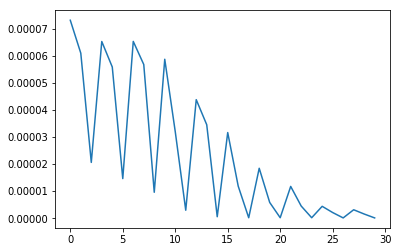

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_lossses)

In [ ]:
for examples in get_iterator(train,batch_size=len(train),train=True,shuffle=True,repeat=False):
    x = examples.comment_text
        
    y = torch.stack([
            examples.toxic,examples.severe_toxic,examples.obscene,examples.threat,examples.insult,examples.identity_hate
        ],dim=1) 
        
    hidden=repackage_hidden(hidden)
    output, hidden = mModal(x, hidden)
    
    acc = get_Accurcy(output,y)
    
    
    

In [2]:
a=[[1,2,3],[4,5,6]]

In [3]:
a[-1]

[4, 5, 6]